In [1]:
# https://developers.google.com/optimization/introduction/python

In [2]:
%reset -sf
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from ortools.linear_solver import pywraplp

# Define problem

In [3]:
# Define four parallel arrays: start_nodes, end_nodes, capacities, and unit costs
# between each pair. For instance, the arc from node 0 to node 1 has a
# capacity of 15 and a unit cost of 4.

import pandas as pd

edges = pd.DataFrame()
edges["start_nodes"] = [ 0, 0,  1, 1,  1,  2, 2,  3, 4]
edges["end_nodes"]   = [ 1, 2,  2, 3,  4,  3, 4,  4, 2]
edges["unit_costs"]  = [ 4, 4,  2, 2,  6,  1, 3,  2, 3]
edges["capacities"]  = [15, 8, 20, 4, 10, 15, 4, 20, 5]
edges["flows"]       = [ 0, 0,  0, 0,  0,  0, 0,  0, 0]
edges["names"]       = "x"+edges[["start_nodes",
                                  "end_nodes"]].astype(str).apply(''.join, axis=1)
edges.index = edges["names"]

# Define an array of supplies at each node.
supplies = [20, 0, 0, -5, -15]

In [4]:
# def augment_nodes(supplies, edges):
#     for i,ss in enumerate(supplies):
#         edges.loc[len(edges)] = [i, len(supplies), 1, 999, 0, 
#                                  "x"+str(i)+str(len(supplies))]
#     supplies.append(-sum(supplies))
#     edges.index = edges["names"]
#     return supplies, edges

In [5]:
# supplies, edges = augment_nodes(supplies, edges)
# edges

# Generate adjacency matrix

In [6]:
num_nodes = len(supplies)

In [7]:
def get_adjacency_matrix(edges):
    start_nodes = edges["start_nodes"]
    end_nodes = edges["end_nodes"]
    unit_costs = edges["unit_costs"]
    capacities = edges["capacities"]
    flows = edges["flows"]
    names = edges["names"]
    
    matrix_unit_costs = [[0 for _ in range(num_nodes)] for _ in range(num_nodes)]
    matrix_capacities = [[0 for _ in range(num_nodes)] for _ in range(num_nodes)]
    matrix_flows      = [[0 for _ in range(num_nodes)] for _ in range(num_nodes)]
    matrix_names      = [["x"+str(i)+str(j)
                          for i in range(num_nodes)] 
                         for j in range(num_nodes)]
    
    for x,y,z,c,f,n in zip(start_nodes, end_nodes, unit_costs, capacities, flows, names):
        matrix_unit_costs[x][y] = z
        matrix_capacities[x][y] = c
        matrix_flows     [x][y] = f
        
    for y,x,z,c,f,n in zip(start_nodes, end_nodes, unit_costs, capacities, flows, names):
        matrix_unit_costs[x][y] = z
        matrix_capacities[x][y] = c
        matrix_flows     [x][y] = f

    return matrix_unit_costs, matrix_capacities, matrix_flows, matrix_names

matrix_unit_costs, matrix_capacities, matrix_flows, matrix_names = get_adjacency_matrix(edges)

In [8]:
# matrix_unit_costs, matrix_capacities, matrix_flows, matrix_names

In [9]:
def plot_graph(supplies, edges):
    start_nodes = edges["start_nodes"]
    end_nodes = edges["end_nodes"]
    unit_costs = edges["unit_costs"]
    capacities = edges["capacities"]
    flows = edges["flows"]
    names = edges["names"]

    G = nx.DiGraph()
    for x,y,z,c,f,n in zip(start_nodes, end_nodes, unit_costs, capacities, flows, names):
        G.add_edge(x, y, cost=z, capacity=c, flow=f, name=n)

    labeldict = {}
    for i,s in enumerate(supplies):
        labeldict[i] = s

    plt.figure(figsize=(14,10))
    pos=nx.circular_layout(G)
    nx.draw_networkx(G,pos, labels=labeldict, with_labels=True,
                     arrowsize=20, width=np.log(flows+1), font_size=15, node_color="yellow")
    nx.draw_networkx_edge_labels(G,pos)
    plt.show()

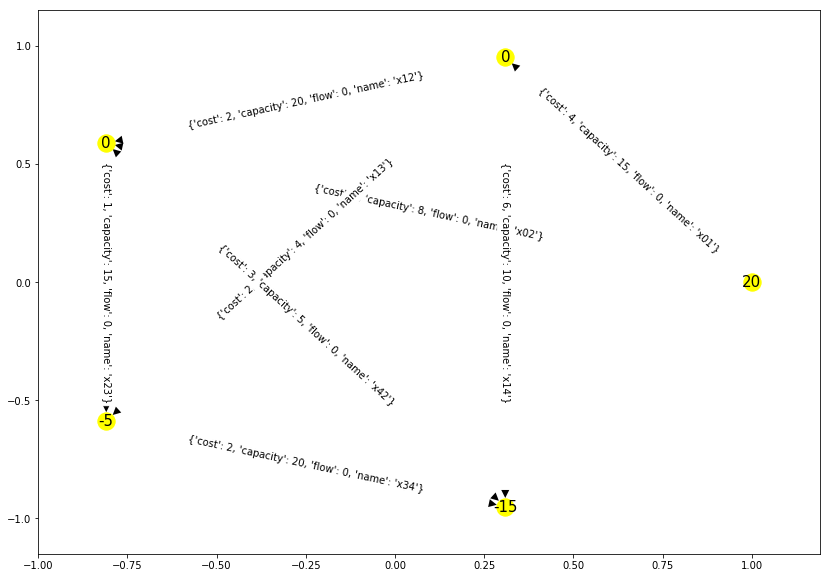

In [10]:
plt.show()
plot_graph(supplies, edges)

# Min-cost flow as a linear program

In [32]:
matrix_names

[['x00', 'x10', 'x20', 'x30', 'x40'],
 ['x01', 'x11', 'x21', 'x31', 'x41'],
 ['x02', 'x12', 'x22', 'x32', 'x42'],
 ['x03', 'x13', 'x23', 'x33', 'x43'],
 ['x04', 'x14', 'x24', 'x34', 'x44']]

In [33]:
solver = pywraplp.Solver('hello_program',
                         pywraplp.Solver.CBC_MIXED_INTEGER_PROGRAMMING)

# define variables and capacities
infinity = solver.infinity()
X = [[solver.IntVar(0.0, matrix_capacities[i][j], 'x'+str(i)+str(j))
      for j in range(num_nodes)]
     for i in range(num_nodes)]

# define supplies
for i in range(num_nodes):
    solver.Add(sum([X[i][j] for j in range(num_nodes)])
             - sum([X[j][i] for j in range(num_nodes)])
            == supplies[i])

# define objective
solver.Minimize(sum([sum([matrix_unit_costs[i][j] * X[i][j]
                          for j in range(num_nodes)])
                     for i in range(num_nodes)]))

# sum[matrix_unit_costs[i][j] * X[i][j] for j in range(num_nodes)]
print('Number of variables =', solver.NumVariables())
print('Number of constraints =', solver.NumConstraints())

Number of variables = 25
Number of constraints = 5


In [34]:
# print(solver.ExportModelAsLpFormat(False).replace('\\', '').replace(',_', ','), sep='\n')

In [35]:
status = solver.Solve()

In [36]:
if status != pywraplp.Solver.OPTIMAL:
    print('The problem does not have an optimal solution.')
    
print('Solution:')
print('Objective value =', solver.Objective().Value())
print('')
print('Advanced usage:')
print('Problem solved in %f milliseconds' % solver.wall_time())
print('Problem solved in %d iterations'   % solver.iterations())
print('Problem solved in %d branch-and-bound nodes' % solver.nodes())

Solution:
Objective value = 150.0

Advanced usage:
Problem solved in 885.000000 milliseconds
Problem solved in 0 iterations
Problem solved in 0 branch-and-bound nodes


In [37]:
matrix_flows = [[x.solution_value() for x in xxx] for xxx in X]
for i,row in enumerate(matrix_flows):
    for j,cell in enumerate(row):
        if matrix_flows[i][j] > 0:
            edges.at["x"+str(i)+str(j),"flows"] = matrix_flows[i][j]

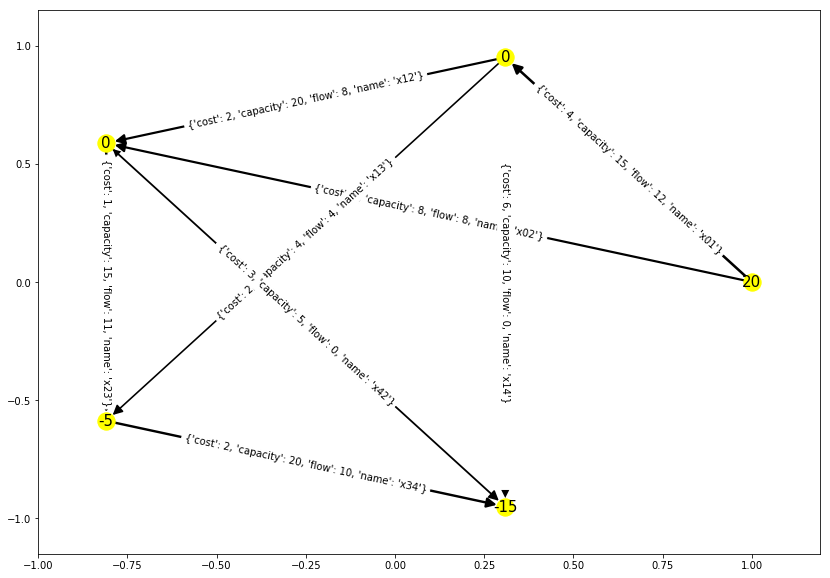

In [38]:
plot_graph(supplies, edges)

In [18]:
edges

,start_nodes,end_nodes,unit_costs,capacities,flows,names
names,,,,,,
x01,0,1,4,15,12,x01
x02,0,2,4,8,8,x02
x12,1,2,2,20,8,x12
x13,1,3,2,4,4,x13
x14,1,4,6,10,0,x14
x23,2,3,1,15,11,x23
x24,2,4,3,4,5,x24
x34,3,4,2,20,10,x34
x42,4,2,3,5,0,x42
